# Comparaison des Solveurs de Sudoku

<< [Sudoku-10-NeuralNetwork](Sudoku-10-NeuralNetwork.ipynb) | [Index](README.md) | [Fin](README.md) >>

Voir aussi : [Search Foundations](../Search/Foundations/) pour les algorithmes sous-jacents

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. Classifier les differentes approches de resolution de Sudoku par categorie (exacte, heuristique, propagation, apprentissage)
2. Comparer objectivement les performances de 4 solveurs Python sur des puzzles de difficulte variee
3. Analyser les forces et faiblesses de chaque approche selon plusieurs criteres (vitesse, fiabilite, scalabilite, simplicite)
4. Choisir le bon solveur en fonction du contexte d'utilisation

### Prerequis
- Avoir lu au moins 3-4 notebooks de la serie Sudoku (Backtracking, OR-Tools, Norvig, un autre au choix)
- Python 3.10+ avec numpy, matplotlib, ortools

### Duree estimee : 35 minutes

## 1. Introduction

Au fil de cette serie de notebooks, nous avons explore **9 approches differentes** pour resoudre le Sudoku. Chacune incarne une philosophie algorithmique distincte :

| # | Notebook | Approche | Philosophie |
|---|----------|----------|-------------|
| 1 | [Backtracking](Sudoku-1-Backtracking.ipynb) | Recherche exhaustive | Explorer systematiquement toutes les possibilites |
| 2 | [Genetic](Sudoku-2-Genetic.ipynb) | Metaheuristique | Faire evoluer une population de solutions candidates |
| 3 | [OR-Tools](Sudoku-3-ORTools.ipynb) | Programmation par contraintes | Declarer les contraintes, laisser le solveur chercher |
| 4 | [Z3](Sudoku-4-Z3.ipynb) | Satisfiabilite (SMT) | Prouver l'existence d'une solution satisfaisant des formules logiques |
| 5 | [Dancing Links](Sudoku-5-DancingLinks.ipynb) | Couverture exacte | Reduire a un probleme de selection de sous-ensembles |
| 6 | [Infer.NET](Sudoku-6-Infer.ipynb) | Inference probabiliste | Propager des distributions de probabilite |
| 7 | [Norvig](Sudoku-7-Norvig.ipynb) | Propagation de contraintes | Eliminer les impossibilites avant de chercher |
| 8 | Simulated Annealing | Recuit simule | Optimiser par perturbations aleatoires avec refroidissement |
| 10 | Neural Network | Apprentissage profond | Apprendre les motifs de resolution a partir d'exemples |

Ce notebook final propose une **comparaison systematique** de ces approches selon plusieurs dimensions : vitesse, fiabilite, elegance du code et scalabilite. Nous implementerons 4 solveurs Python representatifs et les testerons sur un benchmark commun.

In [1]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Dict

# OR-Tools pour le solveur CP-SAT
from ortools.sat.python import cp_model

print("Environnement charge avec succes.")
print(f"  numpy {np.__version__}")
print(f"  ortools importe")

Environnement charge avec succes.
  numpy 2.2.6
  ortools importe


## 2. Categories d'approches

Les 9 approches etudiees se regroupent naturellement en **5 grandes categories**, chacune correspondant a un paradigme algorithmique fondamental.

### 2.1 Methodes exactes (garantie de solution)

Ces methodes explorent l'espace de recherche de maniere systematique et **trouvent toujours une solution** si elle existe.

| Methode | Principe | Complexite pratique | Notebook |
|---------|----------|---------------------|----------|
| **Backtracking** | DFS + validation | Rapide (facile), lent (difficile) | [Sudoku-1](Sudoku-1-Backtracking.ipynb) |
| **Backtracking + MRV** | DFS + heuristique MRV | Rapide meme sur puzzles difficiles | [Sudoku-Python-BT](Sudoku-Python-Backtracking.ipynb) |
| **Dancing Links** | Couverture exacte (Algorithm X) | Optimal pour les problemes de couverture | [Sudoku-5](Sudoku-5-DancingLinks.ipynb) |
| **OR-Tools CP-SAT** | CP + SAT + CDCL | Tres rapide, constant | [Sudoku-3](Sudoku-3-ORTools.ipynb) |
| **Z3 SMT** | Satisfiabilite Modulo Theories | Rapide, overhead d'initialisation | [Sudoku-4](Sudoku-4-Z3.ipynb) |

### 2.2 Methodes de propagation

Ces methodes **reduisent l'espace de recherche** en eliminant les valeurs impossibles avant (ou a la place de) la recherche.

| Methode | Principe | Completude | Notebook |
|---------|----------|------------|----------|
| **Norvig** | Elimination + naked singles + DFS de secours | Complet (avec fallback recherche) | [Sudoku-7](Sudoku-7-Norvig.ipynb) |
| **Strategies humaines** | Regles logiques (naked pairs, X-Wing, etc.) | Incomplet sans recherche | (integre dans divers notebooks) |

### 2.3 Methodes heuristiques (pas de garantie)

Ces methodes utilisent des **mecanismes d'optimisation stochastique** et ne garantissent pas de trouver une solution.

| Methode | Principe | Fiabilite | Notebook |
|---------|----------|-----------|----------|
| **Algorithme genetique** | Evolution de populations | Faible sur puzzles difficiles | [Sudoku-2](Sudoku-2-Genetic.ipynb) |
| **Recuit simule** | Perturbations + refroidissement | Moyenne | Sudoku-8 |

### 2.4 Methodes d'apprentissage

| Methode | Principe | Fiabilite | Notebook |
|---------|----------|-----------|----------|
| **Reseau de neurones** | Apprentissage supervise | Approximation, necessite donnees | Sudoku-10 |

### 2.5 Methodes probabilistes

| Methode | Principe | Fiabilite | Notebook |
|---------|----------|-----------|----------|
| **Infer.NET** | Graphe de facteurs, inference bayesienne | Experimentale | [Sudoku-6](Sudoku-6-Infer.ipynb) |

## 3. Implementations Python des solveurs

Pour une comparaison equitable, nous implementons **4 solveurs representatifs** dans le meme environnement Python. Chaque solveur represente une categorie differente.

| Solveur | Categorie | Pourquoi ce choix |
|---------|-----------|-------------------|
| **Backtracking simple** | Recherche exhaustive | Baseline naive, reference de comparaison |
| **Backtracking + MRV** | Recherche avec heuristique | Amelioration classique, montre l'impact des heuristiques |
| **Norvig (propagation)** | Propagation de contraintes | Approche elegante, souvent suffisante sans recherche |
| **OR-Tools CP-SAT** | Solveur industriel | Etat de l'art, reference de performance |

### Classe SudokuGrid commune

Tous les solveurs utilisent la meme representation de grille pour garantir une comparaison equitable.

In [2]:
class SudokuGrid:
    """Representation d'une grille de Sudoku 9x9."""

    def __init__(self, grid: Optional[List[List[int]]] = None):
        if grid is None:
            self.cells = [[0] * 9 for _ in range(9)]
        else:
            self.cells = [row[:] for row in grid]

    @classmethod
    def from_string(cls, s: str) -> 'SudokuGrid':
        """Cree une grille depuis une chaine de 81 caracteres (0 ou . = case vide)."""
        s = s.replace('.', '0').replace(' ', '').replace('\n', '')
        if len(s) != 81:
            raise ValueError(f"Attendu 81 caracteres, recu {len(s)}")
        grid = cls()
        for i in range(81):
            grid.cells[i // 9][i % 9] = int(s[i])
        return grid

    def clone(self) -> 'SudokuGrid':
        return SudokuGrid(self.cells)

    def is_valid_placement(self, row: int, col: int, num: int) -> bool:
        """Verifie si placer num a (row, col) respecte les contraintes."""
        if num in self.cells[row]:
            return False
        if num in [self.cells[r][col] for r in range(9)]:
            return False
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for r in range(box_row, box_row + 3):
            for c in range(box_col, box_col + 3):
                if self.cells[r][c] == num:
                    return False
        return True

    def find_empty(self) -> Optional[Tuple[int, int]]:
        """Trouve la premiere case vide (parcours ligne par ligne)."""
        for r in range(9):
            for c in range(9):
                if self.cells[r][c] == 0:
                    return (r, c)
        return None

    def count_empty(self) -> int:
        return sum(1 for r in range(9) for c in range(9) if self.cells[r][c] == 0)

    def to_string(self) -> str:
        return ''.join(str(self.cells[r][c]) for r in range(9) for c in range(9))

    def __str__(self) -> str:
        lines = []
        for r in range(9):
            if r > 0 and r % 3 == 0:
                lines.append('-' * 21)
            row_str = ''
            for c in range(9):
                if c > 0 and c % 3 == 0:
                    row_str += '| '
                val = self.cells[r][c]
                row_str += (str(val) if val != 0 else '.') + ' '
            lines.append(row_str)
        return '\n'.join(lines)

# Verification rapide
test = SudokuGrid.from_string("003020600900305001001806400008102900700000008006708200002609500800203009005010300")
print("Grille de test:")
print(test)
print(f"Cases vides: {test.count_empty()}")

Grille de test:
. . 3 | . 2 . | 6 . . 
9 . . | 3 . 5 | . . 1 
. . 1 | 8 . 6 | 4 . . 
---------------------
. . 8 | 1 . 2 | 9 . . 
7 . . | . . . | . . 8 
. . 6 | 7 . 8 | 2 . . 
---------------------
. . 2 | 6 . 9 | 5 . . 
8 . . | 2 . 3 | . . 9 
. . 5 | . 1 . | 3 . . 
Cases vides: 49


### 3.1 Solveur 1 : Backtracking simple

L'algorithme le plus intuitif : essayer chaque valeur dans chaque case vide, revenir en arriere si on atteint une impasse. C'est notre **baseline** -- le solveur le plus simple possible.

**Complexite** : O(9^m) dans le pire cas, ou m est le nombre de cases vides.

In [3]:
class BacktrackingSolver:
    """Solveur par backtracking simple (DFS sans heuristique)."""

    def __init__(self):
        self.call_count = 0

    def solve(self, grid: SudokuGrid) -> bool:
        self.call_count = 0
        return self._backtrack(grid)

    def _backtrack(self, grid: SudokuGrid) -> bool:
        self.call_count += 1
        empty = grid.find_empty()
        if empty is None:
            return True  # Toutes les cases remplies

        row, col = empty
        for num in range(1, 10):
            if grid.is_valid_placement(row, col, num):
                grid.cells[row][col] = num
                if self._backtrack(grid):
                    return True
                grid.cells[row][col] = 0  # Backtrack
        return False

# Test rapide
solver_bt = BacktrackingSolver()
g = test.clone()
start = time.time()
solved = solver_bt.solve(g)
elapsed_ms = (time.time() - start) * 1000
print(f"Backtracking simple: resolu={solved}, {solver_bt.call_count} appels, {elapsed_ms:.2f} ms")

Backtracking simple: resolu=True, 201 appels, 0.83 ms


### 3.2 Solveur 2 : Backtracking avec MRV

L'heuristique **MRV** (Minimum Remaining Values) selectionne toujours la case ayant le **moins de valeurs possibles**. Cela detecte les impasses plus tot et reduit drastiquement l'arbre de recherche.

L'amelioration est souvent spectaculaire : de 100x a 1000x moins d'appels recursifs sur les puzzles difficiles.

In [4]:
class MRVBacktrackingSolver:
    """Solveur par backtracking avec heuristique MRV (Minimum Remaining Values)."""

    def __init__(self):
        self.call_count = 0

    def _get_possible(self, grid: SudokuGrid, row: int, col: int) -> List[int]:
        """Retourne les valeurs possibles pour une case donnee."""
        if grid.cells[row][col] != 0:
            return []
        possible = set(range(1, 10))
        possible -= set(grid.cells[row])
        possible -= {grid.cells[r][col] for r in range(9)}
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for r in range(box_row, box_row + 3):
            for c in range(box_col, box_col + 3):
                possible.discard(grid.cells[r][c])
        return list(possible)

    def _find_mrv(self, grid: SudokuGrid) -> Optional[Tuple[int, int, List[int]]]:
        """Trouve la case vide avec le moins de candidats."""
        best = None
        best_count = 10
        for r in range(9):
            for c in range(9):
                if grid.cells[r][c] == 0:
                    possible = self._get_possible(grid, r, c)
                    if len(possible) < best_count:
                        best = (r, c, possible)
                        best_count = len(possible)
                        if best_count == 0:
                            return best  # Impasse detectee
        return best

    def solve(self, grid: SudokuGrid) -> bool:
        self.call_count = 0
        return self._backtrack(grid)

    def _backtrack(self, grid: SudokuGrid) -> bool:
        self.call_count += 1
        result = self._find_mrv(grid)
        if result is None:
            return True
        row, col, possible = result
        if len(possible) == 0:
            return False
        for num in possible:
            grid.cells[row][col] = num
            if self._backtrack(grid):
                return True
            grid.cells[row][col] = 0
        return False

# Test rapide
solver_mrv = MRVBacktrackingSolver()
g = test.clone()
start = time.time()
solved = solver_mrv.solve(g)
elapsed_ms = (time.time() - start) * 1000
print(f"Backtracking MRV: resolu={solved}, {solver_mrv.call_count} appels, {elapsed_ms:.2f} ms")

Backtracking MRV: resolu=True, 50 appels, 6.10 ms


### 3.3 Solveur 3 : Propagation de contraintes (Norvig)

L'approche de Peter Norvig combine deux strategies de propagation :

1. **Elimination** : quand une case recoit une valeur, on retire cette valeur des candidats de tous ses voisins (meme ligne, colonne, bloc)
2. **Naked single** : quand une valeur n'a qu'un seul emplacement possible dans une unite, on l'y assigne

Si la propagation seule ne suffit pas, un **backtracking avec MRV** prend le relais. En pratique, la propagation resout la majorite des puzzles faciles/moyens sans aucune recherche.

In [5]:
class NorvigSolver:
    """Solveur par propagation de contraintes (style Peter Norvig).

    Utilise elimination + naked singles, avec backtracking MRV en fallback.
    Reference : http://norvig.com/sudoku.html
    """

    def __init__(self):
        self.call_count = 0
        # Precalcul des unites et des voisins
        self.rows = 'ABCDEFGHI'
        self.cols = '123456789'
        self.squares = [r + c for r in self.rows for c in self.cols]
        self.unitlist = (
            [[r + c for c in self.cols] for r in self.rows] +            # lignes
            [[r + c for r in self.rows] for c in self.cols] +            # colonnes
            [[r + c for r in rs for c in cs]                             # blocs
             for rs in ('ABC', 'DEF', 'GHI') for cs in ('123', '456', '789')]
        )
        self.units = {s: [u for u in self.unitlist if s in u] for s in self.squares}
        self.peers = {s: set(sum(self.units[s], [])) - {s} for s in self.squares}

    def solve(self, grid: SudokuGrid) -> bool:
        self.call_count = 0
        # Convertir la grille en chaine
        grid_str = grid.to_string()
        values = self._parse_grid(grid_str)
        if values is False:
            return False
        result = self._search(values)
        if result is False:
            return False
        # Ecrire la solution dans la grille
        for i, s in enumerate(self.squares):
            grid.cells[i // 9][i % 9] = int(result[s])
        return True

    def _parse_grid(self, grid_str: str):
        """Initialise les candidats et propage les valeurs initiales."""
        values = {s: '123456789' for s in self.squares}
        for s, d in zip(self.squares, grid_str):
            if d in '123456789':
                if not self._assign(values, s, d):
                    return False
        return values

    def _assign(self, values, s, d):
        """Assigne la valeur d a la case s par elimination de toutes les autres."""
        other_values = values[s].replace(d, '')
        if all(self._eliminate(values, s, d2) for d2 in other_values):
            return values
        return False

    def _eliminate(self, values, s, d):
        """Elimine d des candidats de s et propage."""
        if d not in values[s]:
            return values  # Deja eliminee
        values[s] = values[s].replace(d, '')

        # Si aucun candidat restant : contradiction
        if len(values[s]) == 0:
            return False

        # Si un seul candidat : propager aux voisins
        if len(values[s]) == 1:
            d2 = values[s]
            if not all(self._eliminate(values, s2, d2) for s2 in self.peers[s]):
                return False

        # Si d n'a qu'un seul emplacement dans une unite : l'y assigner
        for u in self.units[s]:
            dplaces = [s2 for s2 in u if d in values[s2]]
            if len(dplaces) == 0:
                return False  # Contradiction
            if len(dplaces) == 1:
                if not self._assign(values, dplaces[0], d):
                    return False
        return values

    def _search(self, values):
        """Recherche DFS avec heuristique MRV."""
        if values is False:
            return False
        self.call_count += 1

        # Verifie si resolu
        if all(len(values[s]) == 1 for s in self.squares):
            return values

        # MRV : choisir la case non resolue avec le moins de candidats
        _, s = min((len(values[s]), s) for s in self.squares if len(values[s]) > 1)

        for d in values[s]:
            result = self._search(self._assign(values.copy(), s, d))
            if result:
                return result
        return False

# Test rapide
solver_norvig = NorvigSolver()
g = test.clone()
start = time.time()
solved = solver_norvig.solve(g)
elapsed_ms = (time.time() - start) * 1000
print(f"Norvig: resolu={solved}, {solver_norvig.call_count} appels, {elapsed_ms:.2f} ms")

Norvig: resolu=True, 1 appels, 1.90 ms


### 3.4 Solveur 4 : OR-Tools CP-SAT

Google OR-Tools est un solveur **industriel** de programmation par contraintes. Au lieu de programmer un algorithme de recherche, on **declare** les contraintes et le solveur fait le reste.

Le modele Sudoku se resume a :
- 81 variables entieres dans {1..9}
- 27 contraintes `AllDifferent` (9 lignes + 9 colonnes + 9 blocs)

C'est l'approche la plus concise et generalement la plus performante.

In [6]:
class ORToolsCPSATSolver:
    """Solveur utilisant Google OR-Tools CP-SAT."""

    def __init__(self):
        self.call_count = 0  # Non applicable, mais conserve pour l'interface

    def solve(self, grid: SudokuGrid) -> bool:
        self.call_count = 1  # Le solveur fait tout en interne
        model = cp_model.CpModel()

        # Variables : cells[i][j] dans {1..9}
        cells = {}
        for i in range(9):
            for j in range(9):
                if grid.cells[i][j] != 0:
                    cells[(i, j)] = model.NewConstant(grid.cells[i][j])
                else:
                    cells[(i, j)] = model.NewIntVar(1, 9, f'c_{i}_{j}')

        # Contraintes AllDifferent : lignes
        for i in range(9):
            model.AddAllDifferent([cells[(i, j)] for j in range(9)])

        # Contraintes AllDifferent : colonnes
        for j in range(9):
            model.AddAllDifferent([cells[(i, j)] for i in range(9)])

        # Contraintes AllDifferent : blocs 3x3
        for br in range(3):
            for bc in range(3):
                model.AddAllDifferent([
                    cells[(br * 3 + r, bc * 3 + c)]
                    for r in range(3) for c in range(3)
                ])

        # Resolution
        solver = cp_model.CpSolver()
        status = solver.Solve(model)

        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            for i in range(9):
                for j in range(9):
                    grid.cells[i][j] = solver.Value(cells[(i, j)])
            return True
        return False

# Test rapide
solver_cpsat = ORToolsCPSATSolver()
g = test.clone()
start = time.time()
solved = solver_cpsat.solve(g)
elapsed_ms = (time.time() - start) * 1000
print(f"OR-Tools CP-SAT: resolu={solved}, {elapsed_ms:.2f} ms")

OR-Tools CP-SAT: resolu=True, 15.74 ms


## 4. Benchmark

Nous testons les 4 solveurs sur **3 niveaux de difficulte** avec 10 puzzles chacun. Tous les puzzles sont codes en dur ci-dessous pour garantir la reproductibilite (pas de dependance a des fichiers externes).

### Jeux de test

| Difficulte | Caracteristiques | Nombre de cases vides |
|------------|------------------|-----------------------|
| **Easy** | Beaucoup d'indices, propagation simple suffit | ~35-45 |
| **Medium** | Indices reduits, necessite un peu de recherche | ~45-55 |
| **Hard** | Tres peu d'indices, cas extremes connus | ~55-60 |

In [7]:
# -- Jeux de test codes en dur --
# Source : Sudoku_Easy51.txt (10 premiers)
EASY_PUZZLES = [
    "003020600900305001001806400008102900700000008006708200002609500800203009005010300",
    "200080300060070084030500209000105408000000000402706000301007040720040060004010003",
    "000000907000420180000705026100904000050000040000507009920108000034059000507000000",
    "030050040008010500460000012070502080000603000040109030250000098001020600080060020",
    "020810740700003100090002805009040087400208003160030200302700060005600008076051090",
    "100920000524010000000000070050008102000000000402700090060000000000030945000071006",
    "043080250600000000000001094900004070000608000010200003820500000000000005034090710",
    "480006902002008001900370060840010200003704100001060049020085007700900600609200018",
    "000900002050123400030000160908000000070000090000000205091000050007439020400007000",
    "001900003900700160030005007050000009004302600200000070600100030042007006500006800",
]

# Source : Sudoku_top95.txt (10 puzzles selectionnes, difficulte medium)
MEDIUM_PUZZLES = [
    "4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......",
    "52...6.........7.13...........4..8..6......5...........418.........3..2...87.....",
    "6.....8.3.4.7.................5.4.7.3..2.....1.6.......2.....5.....8.6......1....",
    "48.3............71.2.......7.5....6....2..8.............1.76...3.....4......5....",
    "....14....3....2...7..........9...3.6.1.............8.2.....1.4....5.6.....7.8...",
    "......52..8.4......3...9...5.1...6..2..7........3.....6...1..........7.4.......3.",
    "6.2.5.........3.4..........43...8....1....2........7..5..27...........81...6.....",
    ".524.........7.1..............8.2...3.....6...9.5.....1.6.3...........897........",
    "6.2.5.........4.3..........43...8....1....2........7..5..27...........81...6.....",
    ".923.........8.1...........1.7.4...........658.........6.5.2...4.....7.....9.....",
]

# Source : Sudoku_hardest.txt (les 11 puzzles les plus difficiles connus)
HARD_PUZZLES = [
    "85...24..72......9..4.........1.7..23.5...9...4...........8..7..17..........36.4.",
    "..53.....8......2..7..1.5..4....53...1..7...6..32...8..6.5....9..4....3......97..",
    "12..4......5.69.1...9...5.........7.7...52.9..3......2.9.6...5.4..9..8.1..3...9.4",
    "...57..3.1......2.7...234......8...4..7..4...49....6.5.42...3.....7..9....18.....",
    "7..1523........92....3.....1....47.8.......6............9...5.6.4.9.7...8....6.1.",
    "1....7.9..3..2...8..96..5....53..9...1..8...26....4...3......1..4......7..7...3..",
    "1...34.8....8..5....4.6..21.18......3..1.2..6......81.52..7.9....6..9....9.64...2",
    "...92......68.3...19..7...623..4.1....1...7....8.3..297...8..91...5.72......64...",
    ".6.5.4.3.1...9...8.........9...5...6.4.6.2.7.7...4...5.........4...8...1.5.2.3.4.",
    "7.....4...2..7..8...3..8.799..5..3...6..2..9...1.97..6...3..9...3..4..6...9..1.35",
    "....7..2.8.......6.1.2.5...9.54....8.........3....85.1...3.2.8.4.......9.7..6....",
]

print(f"Puzzles charges :")
print(f"  Easy:   {len(EASY_PUZZLES)} puzzles")
print(f"  Medium: {len(MEDIUM_PUZZLES)} puzzles")
print(f"  Hard:   {len(HARD_PUZZLES)} puzzles")

# Verification : compter les cases vides par niveau
for name, puzzles in [("Easy", EASY_PUZZLES), ("Medium", MEDIUM_PUZZLES), ("Hard", HARD_PUZZLES)]:
    empties = [SudokuGrid.from_string(p).count_empty() for p in puzzles]
    print(f"  {name}: {min(empties)}-{max(empties)} cases vides (moy: {np.mean(empties):.1f})")

Puzzles charges :
  Easy:   10 puzzles
  Medium: 10 puzzles
  Hard:   11 puzzles
  Easy: 45-57 cases vides (moy: 51.4)
  Medium: 64-64 cases vides (moy: 64.0)
  Hard: 53-59 cases vides (moy: 56.5)


### Execution du benchmark

La fonction `run_benchmark` teste chaque solveur sur chaque ensemble de puzzles et collecte les temps de resolution et le taux de succes. Chaque puzzle est resolu sur une **copie** de la grille pour eviter toute interference entre solveurs.

In [8]:
def run_benchmark(solvers: Dict[str, object],
                   puzzle_sets: Dict[str, List[str]],
                   timeout_s: float = 10.0) -> Dict:
    """Execute le benchmark complet.

    Args:
        solvers: dictionnaire {nom: instance_solveur}
        puzzle_sets: dictionnaire {difficulte: liste_puzzles}
        timeout_s: temps max par puzzle en secondes

    Returns:
        Resultats structures {solver_name: {difficulty: {time_total, time_avg, solved, count}}}
    """
    results = {}

    for solver_name, solver in solvers.items():
        results[solver_name] = {}
        for diff_name, puzzles in puzzle_sets.items():
            total_time = 0.0
            solved_count = 0
            times = []

            for puzzle_str in puzzles:
                grid = SudokuGrid.from_string(puzzle_str)
                start = time.time()
                try:
                    solved = solver.solve(grid)
                except Exception:
                    solved = False
                elapsed = time.time() - start

                if elapsed > timeout_s:
                    solved = False  # Timeout

                total_time += elapsed
                times.append(elapsed * 1000)  # en ms
                if solved:
                    solved_count += 1

            results[solver_name][diff_name] = {
                'time_total_ms': total_time * 1000,
                'time_avg_ms': (total_time / len(puzzles)) * 1000,
                'time_median_ms': float(np.median(times)),
                'solved': solved_count,
                'count': len(puzzles),
                'times_ms': times,
            }

    return results


# Definir les solveurs
solvers = {
    'Backtracking': BacktrackingSolver(),
    'BT + MRV': MRVBacktrackingSolver(),
    'Norvig': NorvigSolver(),
    'OR-Tools CP-SAT': ORToolsCPSATSolver(),
}

# Definir les jeux de test
puzzle_sets = {
    'Easy': EASY_PUZZLES,
    'Medium': MEDIUM_PUZZLES,
    'Hard': HARD_PUZZLES,
}

# Lancer le benchmark
print("Benchmark en cours...")
results = run_benchmark(solvers, puzzle_sets)
print("Termine.")

Benchmark en cours...


Termine.


### Tableau recapitulatif des resultats

Affichons les resultats sous forme de tableau synthetique, puis sous forme graphique.

In [9]:
def print_benchmark_table(results: Dict):
    """Affiche un tableau formatee des resultats du benchmark."""
    difficulties = ['Easy', 'Medium', 'Hard']
    solver_names = list(results.keys())

    # En-tete
    header = f"{'Solveur':<18}"
    for diff in difficulties:
        header += f" | {diff + ' (ms)':>12}  {'Taux':>6}"
    print(header)
    print("-" * len(header))

    # Lignes
    for solver_name in solver_names:
        row = f"{solver_name:<18}"
        for diff in difficulties:
            data = results[solver_name][diff]
            avg_ms = data['time_avg_ms']
            rate = f"{data['solved']}/{data['count']}"
            row += f" | {avg_ms:>12.2f}  {rate:>6}"
        print(row)

print("=== Resultats du benchmark ===\n")
print_benchmark_table(results)

# Resume global
print("\n--- Temps moyen global (toutes difficultes confondues) ---")
for solver_name in results:
    total_ms = sum(results[solver_name][d]['time_total_ms'] for d in ['Easy', 'Medium', 'Hard'])
    total_puzzles = sum(results[solver_name][d]['count'] for d in ['Easy', 'Medium', 'Hard'])
    total_solved = sum(results[solver_name][d]['solved'] for d in ['Easy', 'Medium', 'Hard'])
    print(f"  {solver_name:<18}: {total_ms/total_puzzles:>8.2f} ms/puzzle, "
          f"{total_solved}/{total_puzzles} resolus")

=== Resultats du benchmark ===

Solveur            |    Easy (ms)    Taux |  Medium (ms)    Taux |    Hard (ms)    Taux
---------------------------------------------------------------------------------------
Backtracking       |       275.33   10/10 |    206604.39    3/10 |      1089.78   11/11
BT + MRV           |        23.54   10/10 |      8701.35    5/10 |        98.62   11/11
Norvig             |         3.17   10/10 |        21.72   10/10 |         4.00   11/11
OR-Tools CP-SAT    |        16.07   10/10 |        17.33   10/10 |        18.40   11/11

--- Temps moyen global (toutes difficultes confondues) ---
  Backtracking      : 67122.09 ms/puzzle, 24/31 resolus
  BT + MRV          :  2849.48 ms/puzzle, 26/31 resolus
  Norvig            :     9.45 ms/puzzle, 31/31 resolus
  OR-Tools CP-SAT   :    17.30 ms/puzzle, 31/31 resolus


### Visualisation : temps moyen par difficulte

Le graphique en barres groupees montre le temps moyen de resolution pour chaque solveur sur chaque niveau de difficulte. L'echelle logarithmique permet de comparer des ordres de grandeur tres differents.

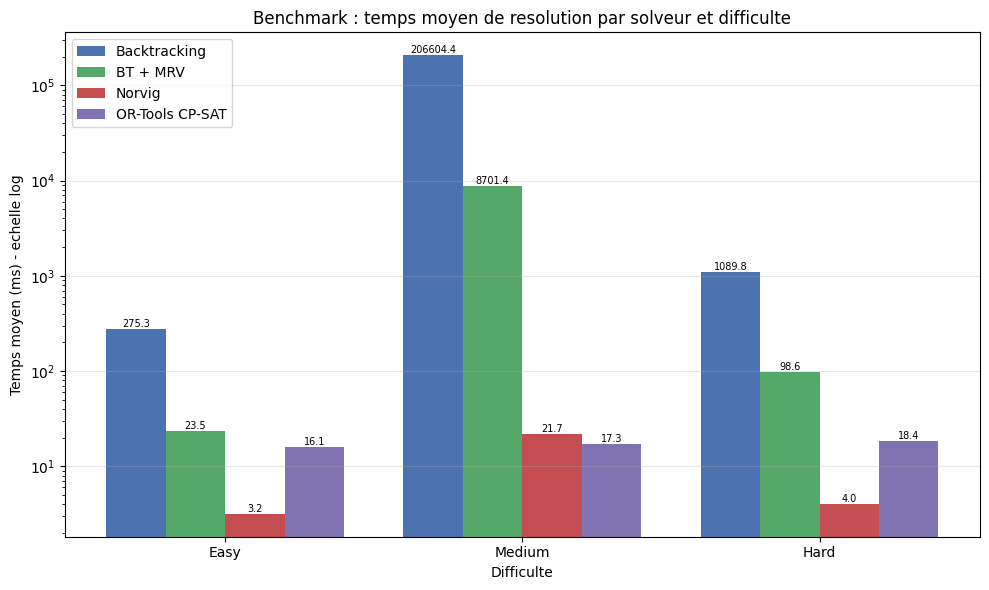

In [10]:
def plot_benchmark_bars(results: Dict):
    """Graphique en barres groupees : temps moyen par difficulte et solveur."""
    difficulties = ['Easy', 'Medium', 'Hard']
    solver_names = list(results.keys())
    n_solvers = len(solver_names)
    n_diffs = len(difficulties)

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(n_diffs)
    width = 0.8 / n_solvers
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

    for i, solver_name in enumerate(solver_names):
        avg_times = [results[solver_name][d]['time_avg_ms'] for d in difficulties]
        offset = (i - n_solvers / 2 + 0.5) * width
        bars = ax.bar(x + offset, avg_times, width, label=solver_name, color=colors[i])

        # Annotations au-dessus des barres
        for bar, val in zip(bars, avg_times):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                        f'{val:.1f}', ha='center', va='bottom', fontsize=7)

    ax.set_xlabel('Difficulte')
    ax.set_ylabel('Temps moyen (ms) - echelle log')
    ax.set_title('Benchmark : temps moyen de resolution par solveur et difficulte')
    ax.set_xticks(x)
    ax.set_xticklabels(difficulties)
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_benchmark_bars(results)

### Visualisation : distribution des temps par solveur

Les boites a moustaches (boxplots) montrent la **variabilite** des temps de resolution. Un solveur avec une boite etroite est plus **previsible** dans ses performances.

C:\Users\jsboi\AppData\Local\Temp\ipykernel_250624\2203822888.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=solver_names, patch_artist=True)
C:\Users\jsboi\AppData\Local\Temp\ipykernel_250624\2203822888.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=solver_names, patch_artist=True)
C:\Users\jsboi\AppData\Local\Temp\ipykernel_250624\2203822888.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=solver_names, patch_artist=True)


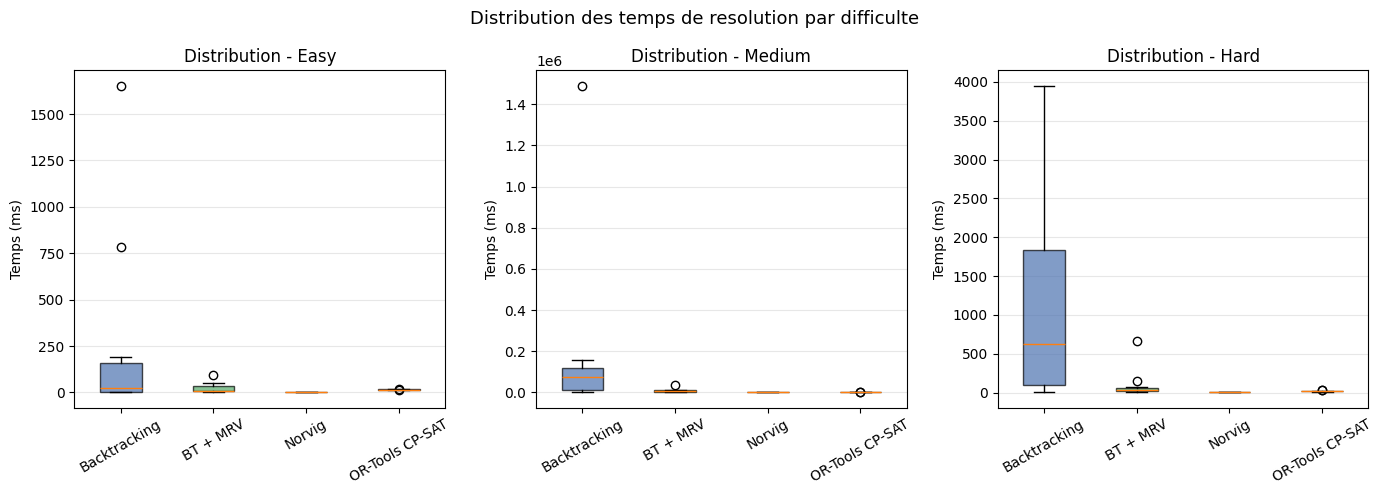

In [11]:
def plot_boxplots(results: Dict):
    """Boxplots de la distribution des temps pour chaque solveur (tous puzzles confondus)."""
    solver_names = list(results.keys())

    fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)
    difficulties = ['Easy', 'Medium', 'Hard']
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

    for ax, diff in zip(axes, difficulties):
        data = [results[s][diff]['times_ms'] for s in solver_names]
        bp = ax.boxplot(data, labels=solver_names, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax.set_title(f'Distribution - {diff}')
        ax.set_ylabel('Temps (ms)')
        ax.tick_params(axis='x', rotation=30)
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Distribution des temps de resolution par difficulte', fontsize=13)
    plt.tight_layout()
    plt.show()

plot_boxplots(results)

### Visualisation : radar multi-criteres

Le graphique radar compare les solveurs sur **5 dimensions** qualitatives. Les scores sont normalises de 1 (faible) a 5 (excellent) pour permettre une vue d'ensemble.

| Critere | Description |
|---------|-------------|
| **Vitesse** | Temps de resolution moyen |
| **Fiabilite** | Taux de resolution sur tous les niveaux |
| **Scalabilite** | Robustesse face a la difficulte croissante |
| **Simplicite** | Nombre de lignes de code, facilite de comprehension |
| **Generalite** | Capacite a s'adapter a d'autres problemes que le Sudoku |

---

---

<< [Sudoku-10-NeuralNetwork](Sudoku-10-NeuralNetwork.ipynb) | [Index](README.md) | [Fin](README.md) >>

**Voir aussi** :
- [Search Foundations](../Search/Foundations/) - Fondamentaux des algorithmes utilisés
- [Search Applications](../Search/Applications/) - Applications des mêmes algorithmes